# Objetivo

Sugerir novos potenciais clientes (*leads*) para um portfólio de entrada com clientes atuais.

# Autores
Bruno Manoel Dobrovolski brunomanoel@dobrovolski.com.br

Fernando Santana Pacheco fspacheco@gmail.com

## Repositório
https://github.com/codenation-dev/squad-1-ad-data-science-1

# Método
Os passos empregados são:

1. Ler arquivo com lista de IDs de clientes atuais
2. Ler banco de dados do mercado (*market*)
3. Processar banco de dados para preencher valores incompletos (NaN) e usar LabelEncoder para variáveis do tipo *object*
4. Gerar modelo com _Nearest Neighbors_ usando banco _market_
5. Buscar novos clientes a partir do cálculo das distâncias entre cada cliente atual e o banco todo, selecionando n clientes com menor distância
6. Apresentar resultados na forma de mapa, gráficos e lista

Com uma base de mais de 460.000 clientes o sistema desenvolvido nesse documento sugere possíveis _leads_ para um portfólio de clientes fornecido como entrada.

As etapas de implementação do sistema contemplam, inicialmente, a leitura da base com a biblioteca `pandas`, o preenchimento de valores nulos de acordo com sua categoria, a codificação através do método de `LabelEncoder` das componentes categóricas para possibilitar a utilização do algoritmo `NearestNeighbors`. Este algoritmo calcula a distância entre o cliente de entrada e os clientes da base completa. São escolhidos aqueles com menor distância.

Os resultados são apresentados com a biblioteca `folium` em um mapa do Brasil, com os clientes atuais em marcadores verdes e os sugeridos, potenciais clientes, em azul. Além disso, ao passar o mouse sobre cada um, são fornecidas informações de identificação e ramo de atividade. Um gráfico das sugestões agrupado pelo faturamento e ramo de atuação também é apresentado.
    

# Preparação (Imports)

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# preprocessing
from sklearn import preprocessing

#Unsupervised Learning
from sklearn.neighbors import NearestNeighbors

#Imports para Visualizações
import folium
from folium import plugins
import random

# Leitura do arquivo de entrada (portfólio com IDs de clientes atuais)
Arquivos recebidos como parte do desafio. Devem ter uma coluna `id`.

In [2]:
port = pd.read_csv('../tests/estaticos_portfolio3.csv',usecols = ['id'])
port.set_index('id',inplace=True)

# Carregamento da Base de dados (Market)
Base de dados em um arquivo formato _feather_ (mais rápido de carregar). O processo de obtenção desse arquivo está descrito em `analysis/Save full market database reduced columns.ipynb`.

In [3]:
import os, wget
market_file = 'estaticos_market.feather'
url_market = 'https://owncloud.ifsc.edu.br/index.php/s/vH4JMIAOuAqvmRc/download'
if not os.path.exists(market_file):
    try:
        #Tip from https://stackabuse.com/download-files-with-python/
        print('Downloading market database...')
        wget.download(url_market, market_file)
        print('Done!')
    except:
        print('Error downloading market database. Check url and connection.')
        raise

print('Opening market database...')
base = pd.read_feather(market_file)
print('Done opening market database.')
base.set_index('id',inplace=True)
base.head(2)

Opening market database...
Done opening market database.


,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,...,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios,idade_media_socios,qt_socios_feminino,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux
id,,,,,,,,,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,...,LESTE POTIGUAR,NATAL,True,2.0,44.0,NaN,"DE R$ 1.500.000,01 A R$ 4.800.000,00","DE R$ 1.500.000,01 A R$ 4.800.000,00",3132172.8,3132172.8
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,False,...,CENTRO NORTE PIAUIENSE,TERESINA,True,1.0,27.0,NaN,"DE R$ 81.000,01 A R$ 360.000,00","DE R$ 81.000,01 A R$ 360.000,00",210000.0,210000.0


# Pré-Processamento
O pré-processamento poderia ser feito de forma separada, mas escolhemos deixá-lo aqui para ter uma visão mais completa do processo.


## Inicialmente identificar como serão preenchidos os NaNs de acordo com seu tipo

In [4]:
fill_dict = base.dtypes.to_dict()
# Categorias em que existiam NaNs e são categóricas, mas deveriam ser booleans
cat2bool = ['fl_optante_simei','fl_optante_simples','fl_passivel_iss']

for feature in fill_dict:
    if(fill_dict[feature] == bool):
        fill_dict[feature] = False
    elif(fill_dict[feature] == object):
        fill_dict[feature] = 'other'
    else:
        fill_dict[feature] = 0
    if feature in cat2bool:
        fill_dict[feature] = False
        
#fill_dict

## Executando o preenchimento de NaNs

In [5]:
base.fillna(value=fill_dict, inplace=True)
base[cat2bool] = base[cat2bool].astype(bool)
bool2numeric = base.columns[base.dtypes == bool]

base[bool2numeric] = base[bool2numeric].astype(int)

## Encoding

In [6]:
cat = base.columns[base.dtypes == object]
not_cat = base.columns[base.dtypes != object]

In [7]:
# Usando LabelEncoder
#https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/

# Create a label (category) encoder object
le = preprocessing.LabelEncoder()

In [8]:
base_le = pd.DataFrame()
base_le[cat] = base[cat].apply(lambda col: le.fit_transform(col))
base_encoded = pd.concat([base[not_cat],base_le], axis =1)
base_encoded.head()


,fl_matriz,idade_empresa_anos,fl_me,fl_sa,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,fl_optante_simples,...,nm_divisao,nm_segmento,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,de_nivel_atividade,nm_meso_regiao,nm_micro_regiao,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo
id,,,,,,,,,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,1,14.457534,0,0,0,0,0,1,1,1,...,32,10,19,4,0,0,6,48,2,2
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,1,1.463014,0,0,1,0,0,1,1,0,...,3,3,16,2,1,1,4,69,10,10
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,1,7.093151,0,0,1,0,0,0,1,1,...,86,20,2,0,0,2,2,43,1,1
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,1,6.512329,0,0,0,0,0,1,1,1,...,74,17,2,0,0,2,2,43,10,10
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,1,3.200000,0,0,0,0,0,1,1,1,...,77,8,19,4,0,0,6,48,10,10


Aplicando encoding ao portfólio.

In [9]:
port_le = base_encoded.merge(port, how='right',left_index=True,right_index=True)
port = base.merge(port, how='right',left_index=True,right_index=True)

# Modelo com Nearest Neighbors 

Como não temos variável-alvo, usamos o treinamento não supervisionado do Nearest Neighbors.

In [10]:
%%time

qtd_neighbors = 5
nearest = NearestNeighbors(n_neighbors=qtd_neighbors, metric = 'cosine')

nearest.fit(base_encoded)


CPU times: user 244 ms, sys: 209 ms, total: 453 ms
Wall time: 459 ms


NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

## Procurando por sugestões

### Calculando os vizinhos mais próximos para o portfólio de clientes

In [11]:
%%time
neighbors_list = {}

for row in range(port_le.shape[0]):
    #print(row)
    neighbors_list[row] = nearest.kneighbors(port_le.iloc[[row]].values)

CPU times: user 2min 8s, sys: 58.3 s, total: 3min 7s
Wall time: 1min 57s


### A resposta é uma lista de distâncias e de sugestões de clientes

In [12]:
neighbors_list

{0: (array([[0.00000000e+00, 5.21570809e-09, 7.22601079e-09, 9.93619420e-09,
          2.14130883e-08]]),
  array([[  3116, 177563, 263040, 176811, 125325]])),
 1: (array([[3.33066907e-16, 1.04161124e-12, 2.79498646e-12, 4.87887508e-12,
          6.24167384e-12]]),
  array([[  3681,   6066, 424650,  29452, 105545]])),
 2: (array([[0.00000000e+00, 6.61803945e-13, 1.20814470e-12, 2.48079335e-12,
          3.13093995e-12]]),
  array([[  4784, 366223, 187429, 236593,  58633]])),
 3: (array([[0.00000000e+00, 5.58963986e-12, 8.60489457e-12, 1.68408620e-11,
          2.91097146e-11]]),
  array([[  7429, 363685, 101411,  96355, 303722]])),
 4: (array([[0.00000000e+00, 1.01096909e-12, 1.40754075e-12, 1.70308212e-12,
          1.89004368e-12]]),
  array([[  8001, 226565, 230358, 354121, 457917]])),
 5: (array([[0.00000000e+00, 1.21073770e-08, 4.08196887e-08, 2.08506287e-07,
          2.89152825e-07]]),
  array([[  8272, 142946,  70177,  39070,  72823]])),
 6: (array([[0.00000000e+00, 1.63535852e

# Avaliação

Agora com o NN funcionando, precisamos analisar as sugestões.

## Analisando as sugestões


Da lista de vizinhos, filtrar os clientes pertencentes ao portfólio de entrada, que aparecem com distância zero.

In [13]:
list_size = len(neighbors_list)
num_neighbors = len(neighbors_list[0][1][0])

neighbors_idx_array = neighbors_list[0][1][0]
neighbors_distance_array = neighbors_list[0][0][0]
np.delete(neighbors_idx_array, [0,1])
np.delete(neighbors_distance_array, [0,1])
for line in range(1,list_size):
    neighbors_idx_array = np.concatenate((neighbors_idx_array, neighbors_list[line][1][0]), axis=None) 
    neighbors_distance_array = np.concatenate((neighbors_distance_array, neighbors_list[line][0][0]), axis=None) 

if len(neighbors_idx_array) != list_size*num_neighbors:
    print("ERROR: Check array size.")
# Temos agora um array unidimensional com os índices dos clientes recomendados)

Como esperado, o cliente mais próximo é ele mesmo.

In [14]:
neighbors_distance_array[0]

0.0

Criar um dicionário com o id de origem da requisição, id do vizinho e distância entre eles.

In [15]:
dicio = {}
for idx,ind in zip(neighbors_idx_array, range(len(neighbors_idx_array))):
    dicio[ind] = (port.iloc[int(ind/qtd_neighbors)].name, base.iloc[idx].name, (neighbors_distance_array[ind]))

In [16]:
dicio

{0: ('bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe24b56a3e11f7d6a0bce',
  'bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe24b56a3e11f7d6a0bce',
  0.0),
 1: ('bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe24b56a3e11f7d6a0bce',
  'e5ac842358b2fd0a6449ed3abe025b1c5a5470e2b4cd24407978072818396d20',
  5.215708087646931e-09),
 2: ('bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe24b56a3e11f7d6a0bce',
  'faa7f1a200e3b2e6da7334ffaef18ff3faf618fa980d165a224c60a592c23ee2',
  7.226010789729287e-09),
 3: ('bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe24b56a3e11f7d6a0bce',
  '25a22502f77a075af92878f748a598fee97116c1f16f7ea73aed52d8553c2c77',
  9.936194200754755e-09),
 4: ('bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe24b56a3e11f7d6a0bce',
  'c06de08966cb55c9a5b316b37ff8d2ba59ef7d3fb2f3ad47bed2183896ddeae1',
  2.1413088302502103e-08),
 5: ('16843c9ffb920170477118933798510d8d5f00f5c56c1221773356355bded321',
  '16843c9ffb920170477118933798510d8d5f00f5c56c1221773356355bded321',
  3.3306690738754696e-16),
 6

### Criando um DataFrame com as sugestões

In [17]:
neig_df = pd.DataFrame.from_dict(dicio,orient='index')
neig_df.rename(columns={0:'id_origin', 1:'id',2:'distance'},inplace = True)
neig_df.set_index('id', inplace=True)

### Identificando os conflitos e removendo da lista de sugestões
Conflitos são os clientes que já pertencem ao portfólio.

In [18]:
conflicts = neig_df.merge(port, how='inner',left_index=True,right_index=True)
suggestion_with_conflicts = neig_df.merge(base, how='left',left_index=True,right_index=True)

suggestions = suggestion_with_conflicts.drop(conflicts.index)

In [19]:
len(conflicts.index.unique()), conflicts.shape, suggestion_with_conflicts.shape, port.shape, suggestions.shape

(265, (502, 39), (1325, 39), (265, 37), (823, 39))

# Visualização dos resultados

## Mapa (Heat)

### Carrega arquivo com informações geográficas
Gerado por `analysis/Save_IBGE_data_for_Map_Visualization_in_Recommendation_System.ipynb`

In [20]:
coord_micro = pd.read_csv('coord_geograficas_microrregioes_brasil.csv')

### Gera lista com coordenadas das sugestões (suggestions)

In [21]:
map_coord = []
null_count = 0  # para verificar quantas sugestões não tem informação da microrregião
for local in suggestions['nm_micro_regiao']:
    coord = coord_micro[coord_micro['nm_micro'] == local][['lat', 'lng']]
    if not coord.empty:
        map_coord.append([coord['lat'].values[0]-random.uniform(0, 0.25),
                          coord['lng'].values[0]-random.uniform(0, 0.25)])
    else:
        null_count = null_count + 1
        # print('Location null', null_count)   #TODO: mostrar como warning
print('Suggestions without info about nm_micro:', null_count)

Suggestions without info about nm_micro: 85


### Mostra heat map

In [22]:
mapa = folium.Map(location=[-8.788497,-53.879873],tiles='Stamen Toner',zoom_start=5)

mapa.add_child(plugins.HeatMap(map_coord))
mapa

## Mapa com marcadores
Passe o mouse sobre os marcadores para informação adicional.

In [23]:
# Para não ter repetições no mapa com marcadores, vou criar um novo df a partir de suggestions,
# deixando só uma entrada para cada id do market
unique_suggestions = pd.DataFrame()
for client in suggestions['id_origin'].unique():
    idxmin_distance = suggestions[suggestions['id_origin']==client]['distance'].idxmin()
    unique_suggestions = unique_suggestions.append(base.loc[idxmin_distance])

In [24]:
# Para verificar quantas sugestões não tem informação da microrregião
uniq_map_coord = []
null_count = 0  
for local in zip(unique_suggestions[['nm_micro_regiao', 'de_ramo']].to_numpy(),
                 unique_suggestions[['nm_micro_regiao', 'de_ramo']].index):
    coord = coord_micro[coord_micro['nm_micro'] == local[0][0]][['lat', 'lng']]
    if not coord.empty:
        uniq_map_coord.append([coord['lat'].values[0]-random.uniform(0, 0.5),
                          coord['lng'].values[0]-random.uniform(0, 0.5),
                          'id:'+local[1][:10]+' ramo:'+local[0][1]]) # para o popup com 
                          #informação do id (aqui, cortado em 10 caracteres) e ramo da empresa de sugestão.
    else:
        null_count = null_count + 1
        # print('Location null', null_count)   #TODO: mostrar como warning

print('Suggestions without info about nm_micro:', null_count)

Suggestions without info about nm_micro: 31


In [25]:
#incluir também clientes atuais
current_map_coord = []
null_count = 0  # para verificar quantas sugestões não tem informação da microrregião
for local in zip(port[['nm_micro_regiao', 'de_ramo']].to_numpy(),
                 port[['nm_micro_regiao', 'de_ramo']].index):
    coord = coord_micro[coord_micro['nm_micro'] == local[0][0]][['lat', 'lng']]
    if not coord.empty:
        current_map_coord.append([coord['lat'].values[0]-random.uniform(0, 0.5),
                          coord['lng'].values[0]-random.uniform(0, 0.5),
                          'id:'+str(local[1])[:10]+' ramo:'+local[0][1]]) # para o popup com 
                          #informação do id e ramo da empresa de sugestão.
    else:
        null_count = null_count + 1
        # print('Location null', null_count)   #TODO: mostrar como warning

print('Current clients without info about nm_micro:', null_count)

Current clients without info about nm_micro: 24


In [26]:
# Mostra marcadores com informação do id e ramo da empresa de sugestão.
markmapa = folium.Map(location=[-8.788497, -53.879873],
                  tiles='OpenStreetMap', zoom_start=5)

tooltip = 'Click for info'
#clientes atuais
for mark in current_map_coord:
    folium.Marker([mark[0], mark[1]],
                 popup = mark[2],
                 tooltip = mark[2],
                 icon=folium.Icon(icon='ok', color='green')).add_to(markmapa)
    
for mark in uniq_map_coord:
    # sugestões
    folium.Marker([mark[0], mark[1]], popup=mark[2], tooltip=mark[2]).add_to(markmapa)

markmapa


## Gráfico de potenciais novos clientes por setor e faixa de faturamento

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


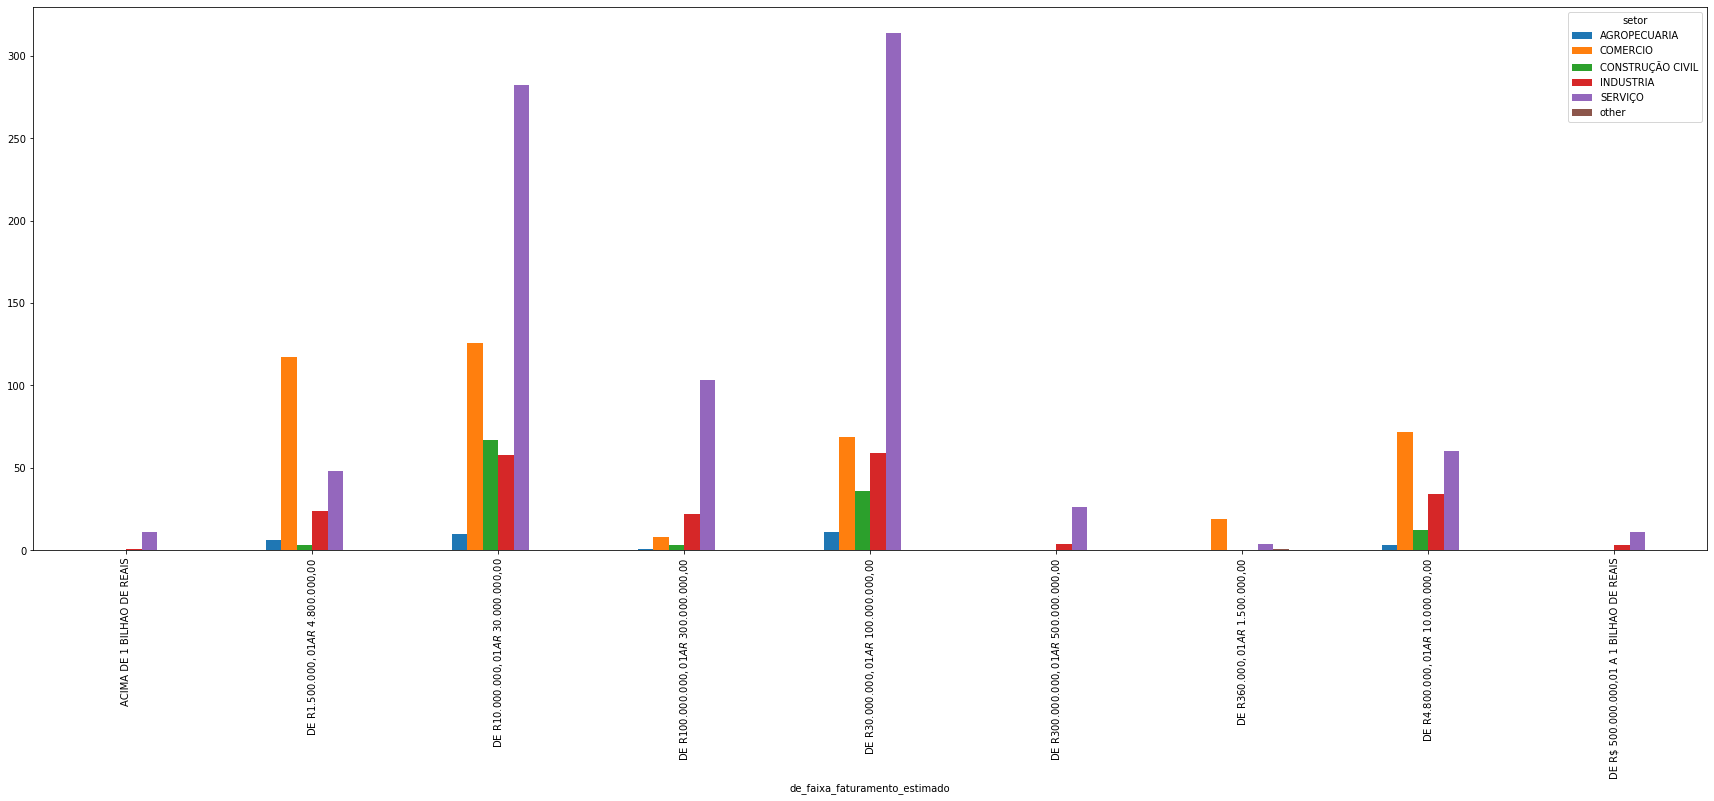

In [28]:
suggestions_gb = suggestions.groupby('de_faixa_faturamento_estimado')
suggestions_gb['setor'].value_counts().unstack().plot.bar(figsize = (30,10)).get_figure().savefig('output.eps')


## Lista de potenciais novos clientes

In [28]:
suggestions

,id_origin,distance,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,...,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios,idade_media_socios,qt_socios_feminino,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux
id,,,,,,,,,,,,,,,,,,,,,
00489ba3f0d05b82ff626d66bf32769dff5ba75303bc9b48f2e971e14369de79,77448dad6e39ab8d5ec8a65c3d830e069952f3dd1e793e...,1.680767e-12,1,SOCIEDADE EMPRESARIA LIMITADA,MA,ENTIDADES EMPRESARIAIS,SERVICOS DE EDUCACAO,SERVIÇO,17.312329,15 a 20,...,OESTE MARANHENSE,IMPERATRIZ,1,3.0,58.000000,1.0,"DE R$ 30.000.000,01 A R$ 100.000.000,00","DE R$ 30.000.000,01 A R$ 100.000.000,00",58058532.0,58058532.0
00ac2b0f09807d4304312374622e5e6a99337ba14858d30f9f546dc01fc8c5de,1874480abbdaa49cb5559c09d8bbe0427be0cf6c65b377...,9.624301e-12,1,SOCIEDADE EMPRESARIA LIMITADA,MA,ENTIDADES EMPRESARIAIS,PRODUTOS DE AGROPECUARIA,AGROPECUARIA,22.353425,> 20,...,LESTE MARANHENSE,CODO,0,3.0,66.000000,1.0,"DE R$ 10.000.000,01 A R$ 30.000.000,00","DE R$ 10.000.000,01 A R$ 30.000.000,00",16691184.0,16691184.0
00ac2b0f09807d4304312374622e5e6a99337ba14858d30f9f546dc01fc8c5de,3924bb87d5f8121a312b17dd7ced8baf3a6c85e8d570b2...,2.857714e-11,1,SOCIEDADE EMPRESARIA LIMITADA,MA,ENTIDADES EMPRESARIAIS,PRODUTOS DE AGROPECUARIA,AGROPECUARIA,22.353425,> 20,...,LESTE MARANHENSE,CODO,0,3.0,66.000000,1.0,"DE R$ 10.000.000,01 A R$ 30.000.000,00","DE R$ 10.000.000,01 A R$ 30.000.000,00",16691184.0,16691184.0
00be946fe734ae93ec6486bf4d55120fe11fd574e18b2d803699b4009300d562,274de0ca45ee8fdbf0c9715a92950441dffe10394ee189...,1.474189e-07,1,SOCIEDADE EMPRESARIA LIMITADA,MA,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,19.876712,15 a 20,...,NORTE MARANHENSE,AGLOMERACAO URBANA DE SAO LUIS,1,2.0,31.000000,0.0,"DE R$ 10.000.000,01 A R$ 30.000.000,00","DE R$ 10.000.000,01 A R$ 30.000.000,00",19782144.0,24068276.0
00caa97fe41b8db1bf3bd9a585a6fb7e8b44e0f3d82ca6fce497f5b3748c2827,4b437c9a0655c43c7ed1750e1549b4e352c7ac5d838d05...,7.468178e-10,1,SOCIEDADE ANONIMA FECHADA,RO,ENTIDADES EMPRESARIAIS,COMERCIO POR ATACADO,COMERCIO,9.293151,5 a 10,...,other,other,0,2.0,48.000000,1.0,"DE R$ 30.000.000,01 A R$ 100.000.000,00","DE R$ 30.000.000,01 A R$ 100.000.000,00",61201010.0,61411010.0
00d52ce6eaef1a707503861c8928be62148516465217e56a0a6dffb46868d727,8d1c9a37b7181831ef3b1b65fb186a90d7f6bcd0379a73...,1.031897e-11,1,SOCIEDADE EMPRESARIA LIMITADA,AC,ENTIDADES EMPRESARIAIS,PRODUTOS DE AGROPECUARIA,AGROPECUARIA,8.624658,5 a 10,...,VALE DO ACRE,SENA MADUREIRA,1,2.0,0.000000,0.0,"DE R$ 10.000.000,01 A R$ 30.000.000,00","DE R$ 10.000.000,01 A R$ 30.000.000,00",28931386.0,28931386.0
021ac088e5a7462494d919e7b7b0781e9ae5aa8b6a370b2d65c44345f0ecc857,b7812b10d3af52dade607e02866f9b24c00dbfb79f26fd...,1.181277e-13,1,SOCIEDADE ANONIMA FECHADA,AM,ENTIDADES EMPRESARIAIS,QUIMICA-PETROQUIMICA,INDUSTRIA,26.802740,> 20,...,CENTRO AMAZONENSE,MANAUS,0,1.0,45.000000,0.0,"DE R$ 300.000.000,01 A R$ 500.000.000,00","DE R$ 300.000.000,01 A R$ 500.000.000,00",356993000.0,356993000.0
021d2faf177f995a2011eb905d14777ec5091106b121a4bdb7f4a6eac5fd978f,8cc6434ef28ae70191dee5ede8f16fea7acb10020a4b46...,1.564304e-13,1,ORGAO PUBLICO DO PODER EXECUTIVO MUNICIPAL,PI,ADMINISTRACAO PUBLICA,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,20.909589,> 20,...,SUDESTE PIAUIENSE,PICOS,1,0.0,0.000000,0.0,"DE R$ 100.000.000,01 A R$ 300.000.000,00","DE R$ 100.000.000,01 A R$ 300.000.000,00",196533540.0,196533540.0
021d2faf177f995a2011eb905d14777ec5091106b121a4bdb7f4a6eac5fd978f,fb70b694ed5ce5337ff9fe8f8bfb8ff565b6b3026d4768...,1.176725e-12,1,ORGAO PUBLICO DO PODER EXECUTIVO MUNICIPAL,PI,ADMINISTRACAO PUBLICA,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,20.909589,> 20,...,SUDESTE PIAUIENSE,PICOS,1,0.0,0.000000,0.0,"DE R$ 100.000.000,01 A R$ 300.000.000,00","DE R$ 100.000.000,01 A R$ 300.000.000,00",196533540.0,196533540.0
